# 7/8 + 7/9: Time-Series ARMA model

In [2]:
#import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import AR, ARMA, ARIMA
import sklearn.metrics as metrics
import tqdm
from datetime import datetime

%matplotlib inline

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load in data

In [3]:
def get_data(filename_string):
    #print(type(filename_string), filename_string)
    
    #1. read in data
    data = pd.read_csv(filename_string)
    #print(data.shape)
    
    #2. drop null index col, null rows where date does not exist in month
    data.drop(['Unnamed: 0'], axis=1, inplace = True)
    data = data[data['state code'].isnull() == False]
    #print(data.shape)
    
    #3. convert data columns to desired type
    data['issue date'] = pd.to_datetime(data['issue date'])
    data['valid date'] = pd.to_datetime(data['valid date'])
    
    data['record sequence'] = data['record sequence'].astype('int64')
    data['action day']=[True if day == 'Yes' else False for day in data['action day']]    #no missing values
    
    data['urldate'] = pd.to_datetime(data['urldate'])
    #print(data.dtypes)
    
    #4. create calculated data column: feature
    data['categorical'] = [1 if (cat == 'Good' or cat == 'Moderate') else 0 for cat in data['AQI category']]
    #print(data.shape)
    
    return(data)

In [4]:
data = get_data('../Data/data.csv')

In [5]:
#taking too long to load + run so forgoing the larger dataset for this model
#data3 = get_data('data2015_18.csv')

In [6]:
#filtering for observations valid on the date and relevant to SF
    #dropping multiple entries, keeping one entry per VALID DATE
        #alternative to this is averaging across multiple entries

def relevant_data(data = data):
    data = data[data['data type'] == 'O']
    data = data[data['reporting area'] == 'San Francisco']
    data.drop_duplicates(['valid date'], keep = 'first', inplace = True)
    return (data)

In [7]:
data = relevant_data()

In [8]:
data.shape    #leaves model with 358 unique rows: unique VALID DATES

(367, 19)

In [9]:
def plotter1(data, window):
    # Determining rolling statistics:
    data['Rolling AQI value'] = data['AQI value'].rolling(window=window, center=False).mean()
    
    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(data['AQI value'], lw = 1, color='blue', label = 'AQI value');
    mean = plt.plot(data['Rolling AQI value'], lw = 1, ls = 'dashed', color='red', label='Rolling AQI value');
    plt.title('Rolling + Original AQI value over past year')
    plt.legend()
    print('p =', window)

p = 1


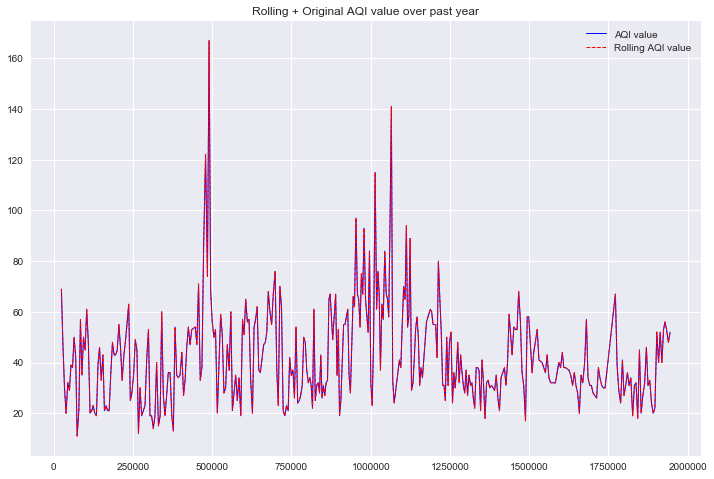

In [10]:
plotter1(data, 1)

p = 2


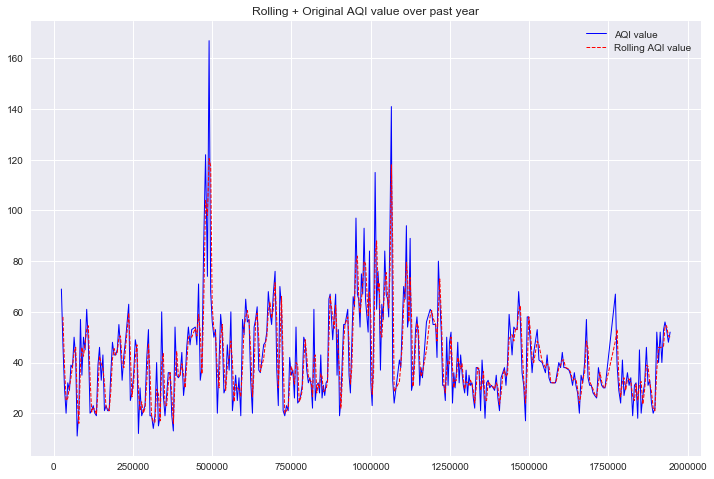

In [11]:
plotter1(data, 2)

p = 3


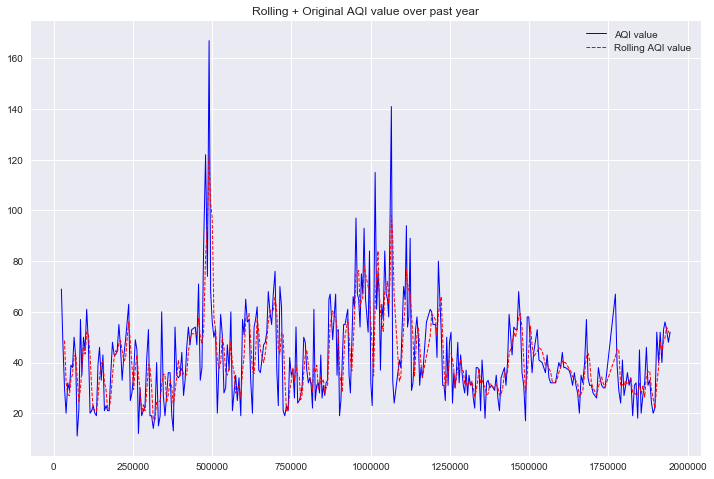

In [12]:
plotter1(data, 3)

p = 5


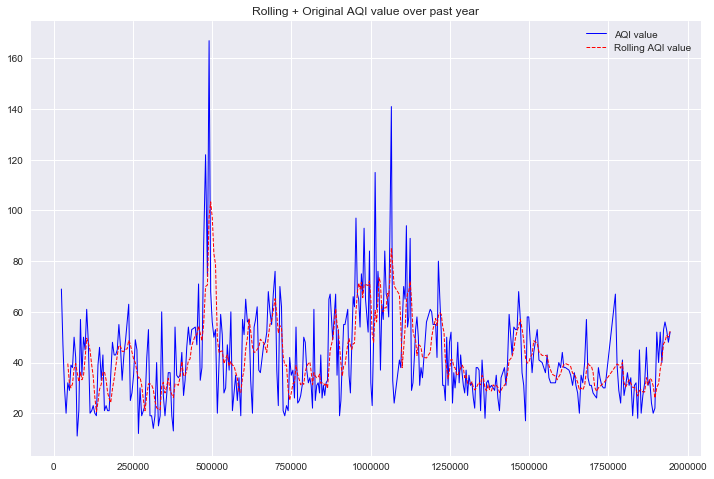

In [13]:
plotter1(data, 5)

p = 15


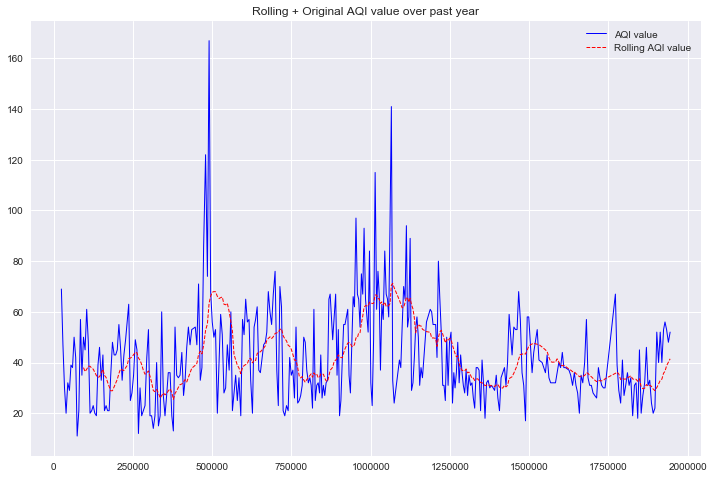

In [14]:
plotter1(data, 15)

p = 90


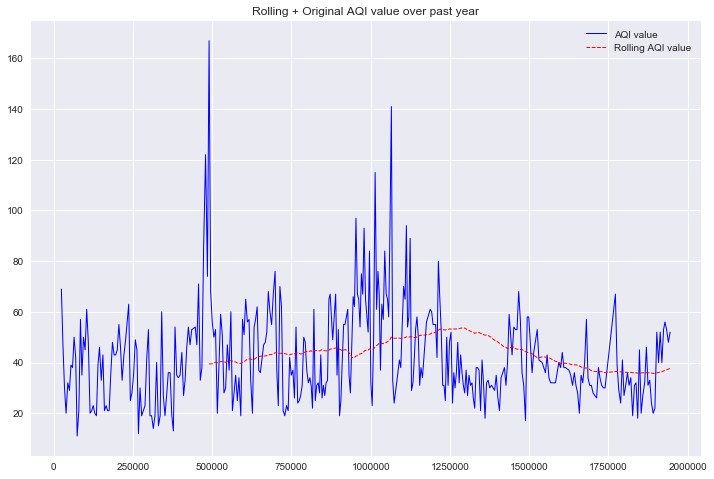

In [15]:
plotter1(data, 90)

In [16]:
print('2 day Lag AutoCorr', np.round(data['AQI value'].autocorr(lag=2), 2))
print('3 day Lag AutoCorr', np.round(data['AQI value'].autocorr(lag=3), 2))
print('5 day Lag AutoCorr', np.round(data['AQI value'].autocorr(lag=5), 2))

2 day Lag AutoCorr 0.32
3 day Lag AutoCorr 0.28
5 day Lag AutoCorr 0.21


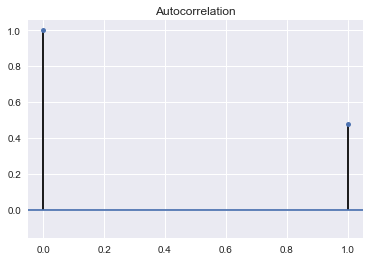

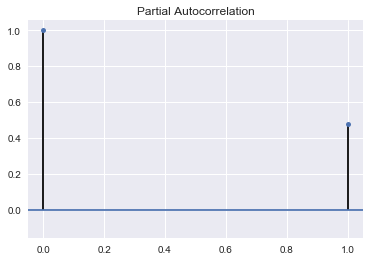

In [17]:
# 1 day Autocorr and Partial Autocorr
plot_acf(data['AQI value'], lags = 1)
plot_pacf(data['AQI value'], lags = 1)
plt.show()

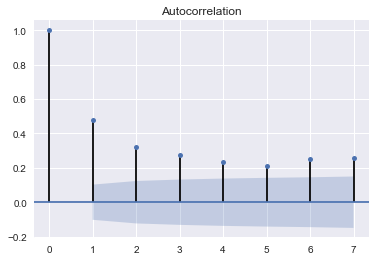

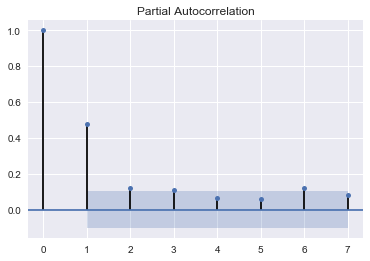

In [18]:
plot_acf(data['AQI value'], lags = 7)
plot_pacf(data['AQI value'], lags = 7)
plt.show()

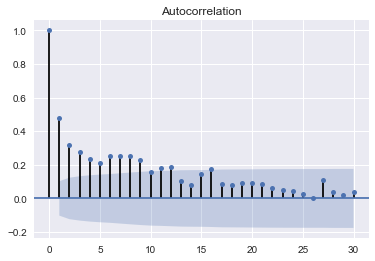

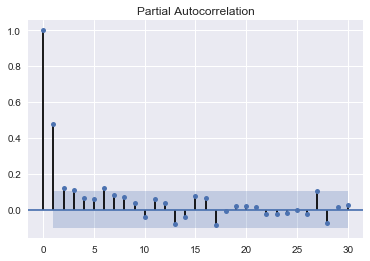

In [19]:
plot_acf(data['AQI value'], lags = 30)
plot_pacf(data['AQI value'], lags = 30)
plt.show()

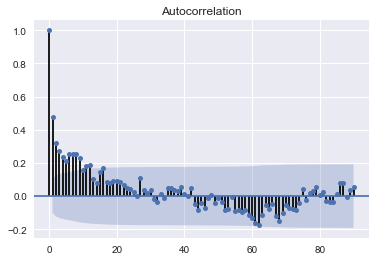

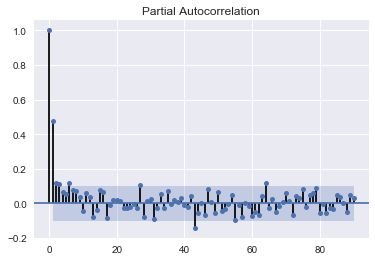

In [20]:
plot_acf(data['AQI value'], lags = 90)
plot_pacf(data['AQI value'], lags = 90)
plt.show()

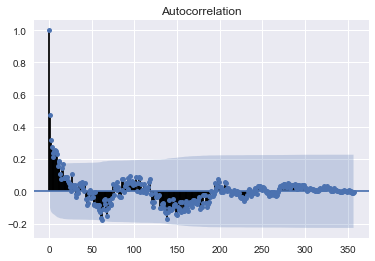

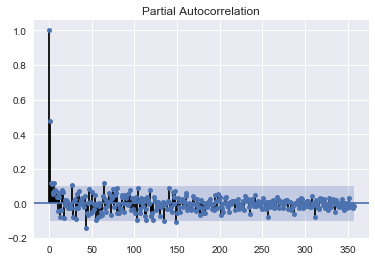

In [21]:
plot_acf(data['AQI value'], lags = 357)
plot_pacf(data['AQI value'], lags = 357)
plt.show()

In [22]:
# Modeling

In [23]:
#split beginning 2/3 of the year to train, last 1/3 of the year to test
    #2/3*358
train_ratio = int(np.round( 2/3 *data.shape[0], 0))
test_ratio = data.shape[0] - train_ratio
print(train_ratio, test_ratio)

train = data[['valid date', 'AQI value']].head(train_ratio)
test = data[['valid date', 'AQI value']].tail(test_ratio)
print(train.shape, test.shape)

245 122
(245, 2) (122, 2)


In [24]:
#set Valid Date col as index
train.set_index(['valid date'], inplace = True)
test.set_index(['valid date'], inplace = True)

In [47]:
train_values = train['AQI value'].values
train_dates = train.index

AR15 = AR(train_values, train_dates).fit()
print('lag:', AR15.k_ar)

#in-sample predictions
AR15_in_pred = AR15.predict(start = 15, end = train_ratio)
len(AR15_in_pred)

lag: 15


231

In [26]:
test_values = test['AQI value'].values
test_dates  = test.index
print(len(test_dates))

# The AR Predict takes a start and and end date as values and not a list.
start = datetime(2018, 2, 12)
end = datetime(2018, 6, 21)

#datetimeindex issue

#out-of-sample predictions
AR15_pred = AR15.predict(start = 15, end = 122)

122


In [27]:
# Evaluate

In [28]:
len(AR15_pred), len(test_values)

(108, 122)

In [29]:
AR15_pred

array([49.15749252, 43.95271654, 48.47505292, 44.45339325, 34.84996286,
       35.68851302, 33.28978863, 28.62236728, 37.70820324, 42.76904633,
       39.08933594, 32.15246992, 41.02264874, 30.44124221, 30.41370247,
       27.69898631, 32.56508868, 41.07512482, 40.5126502 , 39.72205407,
       42.93483566, 39.2091473 , 43.18612624, 43.46500648, 40.20317575,
       42.62619459, 47.45447712, 49.49974079, 55.35550643, 39.6003609 ,
       36.42698692, 37.01001479, 46.42158922, 48.62397235, 31.36732571,
       33.97795358, 31.89873873, 32.54634178, 34.94359624, 36.95722896,
       40.28284897, 30.06107762, 33.30469167, 28.13129628, 25.41365671,
       36.20343804, 30.59390953, 32.75612184, 40.30543909, 31.95857722,
       34.29158649, 30.88816389, 29.61087406, 37.63873432, 33.56990938,
       29.45662074, 43.89477974, 31.72791334, 38.48191153, 42.02407546,
       35.26109453, 30.27150827, 40.96710408, 43.69019043, 46.15354889,
       40.60838808, 47.96387186, 50.89452151, 45.11820039, 50.33

In [30]:
metrics.mean_absolute_error(test_values[14:], AR15_pred)

11.465294262251982

In [31]:
AR15_residuals = test_values[14:] - AR15_pred

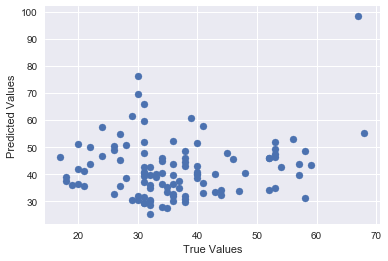

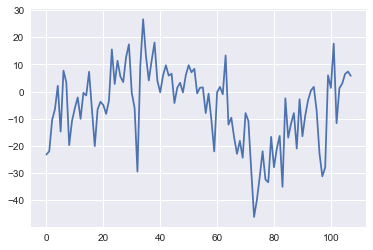

In [32]:
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.scatter(test_values[14:], AR15_pred)
plt.show()

plt.plot(AR15_residuals)
plt.show()

In [33]:
udiff = data['AQI value'].diff(periods = 1)
udiff_1 = udiff[1:]

In [34]:
#another try
p = 1
q = 0

AR1 = ARMA(udiff_1.values, (p, q)).fit()

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [35]:
#in-sample predictions
AR1_insample = AR1.predict(start = 1, end = train_ratio-1)    #start and end seem to be inclusive in model
len(AR1_insample)

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


244

In [36]:
AR1_insample, np.cumsum(AR1_insample)


(array([  7.59802297,   5.86084725,   3.42880125,  -4.21477191,
          0.99675524,  -3.51990163,   0.30188495,  -4.21477191,
          2.73393096,  10.72493926,  -3.51990163, -12.55321536,
          7.59802297,  -5.25707735,   1.69162553,  -5.60451249,
          4.47110668,   9.68263383,  -0.39298533,  -0.74042048,
          0.99675524,   0.30188495,  -6.99425306,  -2.4775962 ,
          4.47110668,  -3.51990163,   7.59802297,  -0.74042048,
          0.6493201 ,  -0.04555019,  -4.9096422 ,  -4.56220706,
          1.69162553,  -0.04555019,  -0.74042048,  -3.51990163,
          3.0813661 ,   4.47110668,  -3.51990163,  -2.13016105,
         -2.4775962 ,  -2.4775962 ,  13.15698527,  -1.08785562,
         -2.4775962 ,  -4.9096422 ,   1.34419038,  11.41980955,
         -6.29938278,   3.77623639,  -0.74042048,  -0.74042048,
         -6.64681792,  -3.86733677,  11.7672447 ,  -0.04555019,
          1.69162553,  -1.78272591,  -7.34168821,   8.6403284 ,
         -1.43529077, -14.29039108,  11.

In [37]:
metrics.mean_absolute_error(train_values[1:], AR1_insample)

45.116535064058375

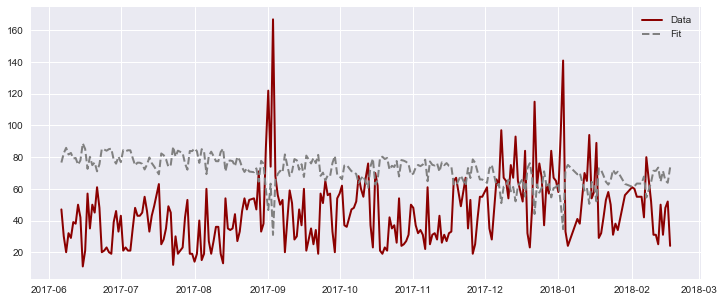

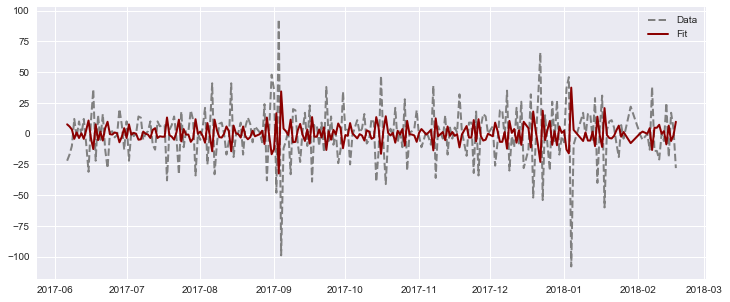

In [38]:
full_pred = data['AQI value'].values[0] + np.cumsum(AR1_insample)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data['valid date'][1:train_ratio], data['AQI value'][1:train_ratio], lw=2, color='darkred', label='Data')
ax.plot(data['valid date'][1:train_ratio], full_pred, lw=2, color='grey', ls='dashed', label='Fit')
plt.legend()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data['valid date'][1:train_ratio], udiff[1:train_ratio], lw=2, color='grey', ls='dashed',label='Data')
ax.plot(data['valid date'][1:train_ratio], AR1_insample, lw=2, color='darkred',label='Fit')
plt.legend()
plt.show()

In [39]:
#out-of-sample predictions
AR1_outsample = AR1.predict(start = len(data) - test_ratio, end = len(udiff_1)-1)
len(AR1_outsample)
metrics.mean_absolute_error(test_values[1:], AR1_outsample)


/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


36.33760344195675

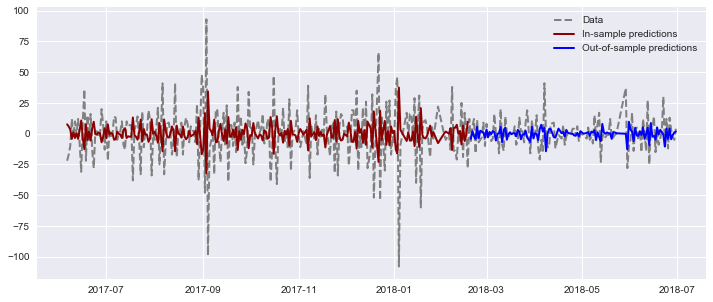

In [50]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(data['valid date'][:], udiff, lw=2, color='grey', ls='dashed', label='Data')
ax.plot(data['valid date'][1:train_ratio], AR1_insample , lw=2, color='darkred', label='In-sample predictions')
ax.plot(data['valid date'][train_ratio+1:len(data)], AR1_outsample, lw=2, color='blue', label='Out-of-sample predictions')
plt.legend()
plt.show()

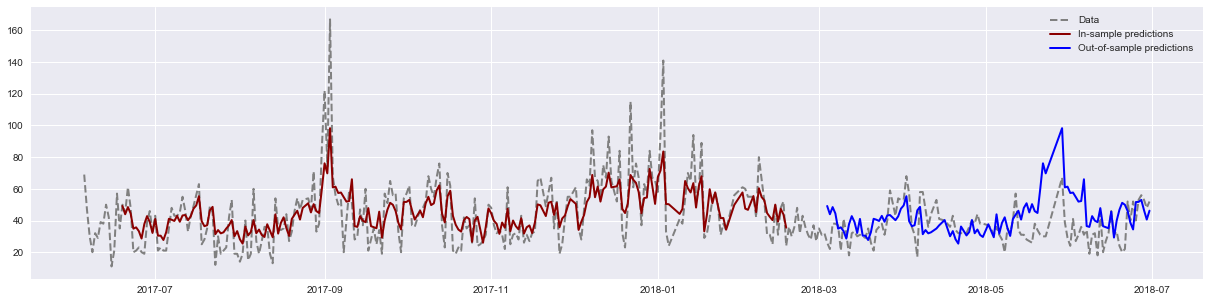

In [61]:
#for lag = 15, plot predictions against actual
fig, ax = plt.subplots(figsize=(21,5))
ax.plot(data['valid date'][:], data['AQI value'], lw=2, color='grey', ls='dashed', label='Data')
ax.plot(train_dates[14:train_ratio], AR15_in_pred, lw=2, color='darkred', label='In-sample predictions')
ax.plot(test_dates[14:], AR15_pred, lw=2, color='blue', label='Out-of-sample predictions')
plt.legend()
plt.show()

# Iteration over multiple p values

In [ ]:
#clear variables first
del p, q

In [218]:
def mae(p):
    udiff = data['AQI value'].diff(periods = p)
    udiff_p = udiff[p:]
    p = p
    q = 0
    AR_p = ARMA(udiff_p.values, (p, q)).fit()
    AR_p_insample = AR_p.predict(start = p, end = train_ratio-1)
    mae_train = np.round(metrics.mean_absolute_error(train_values[p:], AR_p_insample), 2)
    #print('MAE train:', mae_train)
    
    AR_p_outsample = AR_p.predict(start = train_ratio+p, end = len(data)-1)
    mae_test = np.round(metrics.mean_absolute_error(test_values[p:], AR_p_outsample), 2)
    #print('MAE sum:', mae_train+mae_test)
    #return ('MAE test:', mae_test)
    return (mae_test)

In [219]:
mae(1)

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


36.31

In [220]:
mae(15)

/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/chelen/anaconda3/envs/dsi/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


35.79

In [225]:
warnings.filterwarnings('ignore')
repareas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

print('p', 'mae')
for i in repareas:
    print(i, mae(i))
    #print('\n')

p mae
1 36.31
2 36.32
3 36.51
4 36.41
5 36.24
6 36.18
7 36.1
8 36.15
9 36.09
10 35.96
15 35.79
20 35.77
